This notebook performs an analysis on Consumer Finance Complaints dataset.

References:
- https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f

Dataset link: https://catalog.data.gov/dataset/consumer-complaint-database

In [1]:
import pandas as pd
df = pd.read_csv('complaints.csv')
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2020-02-11,Debt collection,I do not know,Attempts to collect debt not owed,Debt was paid,NaN,NaN,First Data Corporation,WA,98109,NaN,NaN,Web,2020-02-11,In progress,Yes,NaN,3528370
1,2020-01-27,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,NaN,NaN,"EQUIFAX, INC.",GA,30238,NaN,NaN,Web,2020-01-27,In progress,Yes,NaN,3509918
2,2020-02-02,Debt collection,Medical debt,Written notification about debt,Didn't receive notice of right to dispute,NaN,NaN,"Commonwealth Financial Systems, Inc.",CA,95330,Servicemember,NaN,Web,2020-02-02,Closed with explanation,Yes,NaN,3517453
3,2020-02-11,Mortgage,FHA mortgage,Trouble during payment process,NaN,NaN,NaN,"FLAGSTAR BANK, FSB",NY,12182,NaN,NaN,Referral,2020-02-11,In progress,Yes,NaN,3528676
4,2020-02-06,Mortgage,Conventional home mortgage,Trouble during payment process,NaN,NaN,NaN,"MONEY SOURCE, THE",MD,207XX,NaN,NaN,Web,2020-02-06,Closed with explanation,Yes,NaN,3522478


The desired columns are ``Product`` (class label) and ``Consumer complaint narrative`` (text documents).

In [2]:
col = ['Product', 'Consumer complaint narrative']
df = df[col]
df = df[pd.notnull(df['Consumer complaint narrative'])]
df.columns = ['Product', 'Consumer_complaint_narrative']
df['category_id'] = df['Product'].factorize()[0]
print(df.isnull().sum())
df.head()

Product                         0
Consumer_complaint_narrative    0
category_id                     0
dtype: int64


,Product,Consumer_complaint_narrative,category_id
10,"Credit reporting, credit repair services, or o...",I HAD FILED WITH CFPB ON XX/XX/XXXX19 TO HAVE ...,0
35,"Credit reporting, credit repair services, or o...","XXXX XXXX XXXX, which went bankrupt a differen...",0
36,"Credit reporting, credit repair services, or o...",I kept receiving calls from a company stating ...,0
37,Debt collection,This is a reverse credit card complaint. \n\nM...,1
42,"Credit reporting, credit repair services, or o...",I was unable to request a security freeze with...,0


Cheking classes distribution.

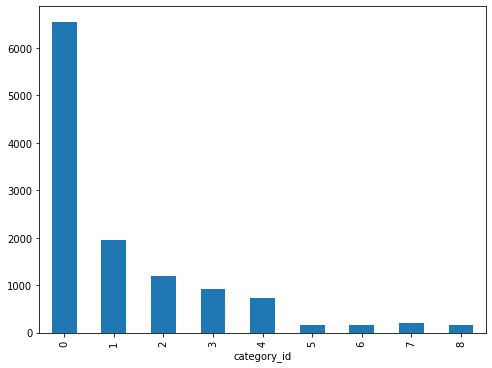

category_id
0    6552
1    1952
2    1200
3     921
4     719
5     164
6     151
7     191
8     163
Name: Consumer_complaint_narrative, dtype: int64

In [3]:
%matplotlib inline

from io import StringIO
category_id_df = df[['Product', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
count = df.groupby('category_id').Consumer_complaint_narrative.count()
count.plot.bar(ylim=0)
plt.show()
count

The dataset is unbalanced. Let's limit our analysis to the most frequent categories and create a balanced dataset.

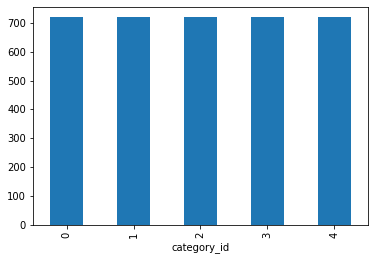

719


In [8]:
df2 = df.drop(df[df['category_id'].isin([5, 6, 7, 8])].index).reset_index(drop=True)
df2.head()

balanced_df = df2.groupby('category_id')
min_size = balanced_df.size().min()
balanced_df = balanced_df.apply(lambda x: x.sample(min_size)).reset_index(drop=True)

count = balanced_df.groupby('category_id').Consumer_complaint_narrative.count()
count.plot.bar(ylim=0)
plt.show()
print(min_size)

Saving our balanced dataset.

In [5]:
balanced_df.to_csv('complaints-balanced.csv')

Analyzing the vocabulary.

`CountVectorizer`
- It doesn't remove stop words.
- `analyzer='word'` word n-grams.
- `token_pattern=r'\w{1,}'` regular expression setting the token's separator (Any alpha, numeric, underline and with at least on character).
- `ngram_range=(1, 2)` account for 1-gram and 2-grams.

In [9]:
%%time
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1, 2))
count_vect.fit(balanced_df['Consumer_complaint_narrative'])

print('Vocabulary size: ', len(count_vect.vocabulary_))

Vocabulary size:  188070
CPU times: user 2.31 s, sys: 28.1 ms, total: 2.34 s
Wall time: 2.34 s


Showing the terms that are the most correlated with each of the products.

In [10]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
features = count_vect.fit_transform(balanced_df.Consumer_complaint_narrative).toarray()
labels = balanced_df.category_id
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(count_vect.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Product))
  print("  . Most correlated unigrams:\n    . {}".format('\n    . '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n    . {}".format('\n    . '.join(bigrams[-N:])))

# 'Checking or savings account':
  . Most correlated unigrams:
    . account
    . bank
  . Most correlated bigrams:
    . checking account
    . the bank
# 'Credit card or prepaid card':
  . Most correlated unigrams:
    . citi
    . card
  . Most correlated bigrams:
    . the card
    . credit card
# 'Credit reporting, credit repair services, or other personal consumer reports':
  . Most correlated unigrams:
    . i
    . the
  . Most correlated bigrams:
    . inquiry date
    . date xx
# 'Debt collection':
  . Most correlated unigrams:
    . xx
    . debt
  . Most correlated bigrams:
    . xx xx
    . the debt
# 'Money transfer, virtual currency, or money service':
  . Most correlated unigrams:
    . extensive
    . extensively
  . Most correlated bigrams:
    . extensively unnecessary
    . zoning says
# 'Mortgage':
  . Most correlated unigrams:
    . loan
    . mortgage
  . Most correlated bigrams:
    . my mortgage
    . the loan
# 'Payday loan, title loan, or personal loan':
  .

Showing the `N` most frequent terms.

In [12]:
N = 50
sum_words = count_vect.transform(balanced_df['Consumer_complaint_narrative']).sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in count_vect.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
for word, freq in words_freq[:N]:
    print(word, freq)

xxxx 36769
the 35288
i 29324
to 27722
and 21762
xx 17537
my 15958
a 15899
of 14311
xxxx xxxx 13800
that 12459
was 10845
on 10018
in 9660
xx xx 8733
this 8469
they 8325
not 8153
have 7613
for 7550
me 7384
is 7285
with 6860
account 6673
xx xxxx 6189
it 5908
credit 5289
00 4667
from 4617
as 4329
be 3961
had 3522
i have 3494
bank 3471
or 3117
on xx 3047
an 2856
would 2821
by 2807
at 2806
of the 2745
card 2658
i was 2623
no 2607
them 2581
payment 2559
been 2520
are 2492
that i 2397
has 2325


We can see that there are several words containing only the letter x (XX, XXX, ...). These words are hiding private data. Let's list all te words contaning the letter x.

In [19]:
count_vect2 = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect2.fit(balanced_df['Consumer_complaint_narrative'])
for word, idx in count_vect2.vocabulary_.items():
    if "x" in word:
        print(word)

xxxx
xx
expedite
experian
explained
blockexcept
exception
except
exercise
exactly
examine
experion
exceed
fix
next
equifax
extremely
executive
existing
fixing
exchange
example
fixed
faxed
exact
xxxxxxxxxxxxxx
expiring
explain
tax
exempt
exist
box
explanation
extent
xxxxxxxx
ex
existed
edxxxx
5xxxx
texas
extreme
taxes
approximately
reportingxxxx
excellent
experience
reportedxx
addressxxxx
explains
explaining
xxxxremoval
jxx
tx
asxx
sincexx
oxx
xxxxi
onxx
extra
extract
nxxxx
sxx
exploration
extraction
export
fax
expieran
experien
inexplicably
numberxxxx
openedxxxx
xxxxunavailable
amex
mixed
expensive
exercising
expect
exhausted
expierian
xxxxyou
txxxxx
explaination
expired
exposed
express
xxxxwith
exists
xxxxand
xxxxcredit
xxxxbank
xxxxtravel
xxxxeducation
extend
expenses
maximum
ohxxxx
xxxxr
expiration
exquifax
xxxxaccount
six
excessive
extended
chexsystems
chexsystem
expend
scorxxxx
xxxxed
exhibit
equfiax
chxxxx
x3
x
complex
lexis
nexis
mix
extension
inxx
text
theextremely
pheonix
phoe